In [1]:
from fbprophet import Prophet
import fbprophet.diagnostics as Prophet_Diagnostics

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from datetime import datetime
import warnings
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import locale
import pickle
from tqdm import tqdm
warnings.filterwarnings('ignore')

from GridSearchProphet import GridSearch

# locale.setlocale(locale.LC_NUMERIC, "deu_deu")

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.formatter.use_locale'] = True

# Reading data

In [2]:
# reading data
c2g_data = pd.read_csv('data/demand_datasets/c2g_demand.csv', index_col=0)

In [3]:
#cleaning process
c2g_data.index = pd.to_datetime(c2g_data.index)

Selecting the period that has less missing data between the three services.

In [4]:
init_period = '2016-12-13 15:00'
end_period = '2017-02-25 17:00'

c2g_data = c2g_data[(c2g_data.index >= init_period) & (c2g_data.index <= end_period)]

# shift the dataset in 24 hours to split the data equals to the time shift models
c2g_data = c2g_data.iloc[24:]

Formating the data to the Prophet dataframe structure, where the timestamps stay in the ds collumn and the values in the y column.

In [5]:
def to_prophet_data(data):
    """
        Convert a time series list to the prophet data structure
    """
    prophet_data = pd.DataFrame(list(zip(data.index, data.travels)), columns=['ds','y'])
    prophet_data.sort_values(by='ds',inplace=True)
    prophet_data.reset_index(inplace=True, drop=True)
    
    return prophet_data

In [6]:
#prophet data structure

c2g_prophet = to_prophet_data(c2g_data)

In [7]:
c2g_prophet.tail()

,ds,y
1750,2017-02-25 13:00:00,209
1751,2017-02-25 14:00:00,212
1752,2017-02-25 15:00:00,214
1753,2017-02-25 16:00:00,236
1754,2017-02-25 17:00:00,256


## Prophet forecast

During the selected periods there is a occurence of the Canada Day, so him will be included as parameters to the models.

In [8]:
holidays = pd.DataFrame([{
  'holiday': 'Christmas_day',
  'ds': pd.to_datetime('2016-12-25'),
  'lower_window': 0,
  'upper_window': 1,
}, {
  'holiday': 'New_Year',
  'ds': pd.to_datetime('2017-01-01'),
  'lower_window': 0,
  'upper_window': 1,
}, {
  'holiday': 'Family_day',
  'ds': pd.to_datetime('2017-02-13'),
  'lower_window': 0,
  'upper_window': 1,
}, {
  'holiday': 'Valentine_day',
  'ds': pd.to_datetime('2017-02-14'),
  'lower_window': 0,
  'upper_window': 1,
}])

In [9]:
# splitting in train (80%) and test data (20%)
def split(data, perc=0.8):
    index = int(len(data)*0.8)
    return data[:index], data[index:]

c2g_train, c2g_test = split(c2g_prophet)

In [10]:
c2g_test.head()

,ds,y
1404,2017-02-11 03:00:00,151
1405,2017-02-11 04:00:00,125
1406,2017-02-11 05:00:00,80
1407,2017-02-11 06:00:00,54
1408,2017-02-11 07:00:00,28


## Fine Tunning the models

Perform a Grid Search with a set of parameters to each service data.
The validation data will be selected from the last 20% of the train set.

In [13]:
# Possible parameters combinations
params = {
    'growth': ['linear'],
    'weekly_seasonality': [True], 
    'yearly_seasonality': [False], 
    'daily_seasonality': [True],
    'changepoint_range': [0.5, 0.6, 0.7, 0.8, 0.9],
    'n_changepoints': [10, 25, 35, 45, 50, 55],
    'changepoint_prior_scale': [0.006, 0.008, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5],
    'seasonality_mode': ['multiplicative'],
    'seasonality_prior_scale': [0.1, 0.5, 1, 10, 20, 30, 40, 50],
    'holidays_prior_scale':[0.1, 0.5, 1, 5, 10, 30, 50],
    'holidays': [holidays]
}

In [14]:
c2g_grid_search = GridSearch(estimator=Prophet, params=params, scoring='mae', cv=1)

In [15]:
c2g_grid_search.fit(c2g_train)

100%|█████████████████████████████████████████████████████████████████████████| 13440/13440 [15:50:25<00:00,  6.90s/it]


Services best parameters finded.

In [16]:
# sem cv
print(c2g_grid_search.best_params_)

{'growth': 'linear', 'weekly_seasonality': True, 'yearly_seasonality': False, 'daily_seasonality': True, 'changepoint_range': 0.9, 'n_changepoints': 25, 'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10, 'holidays_prior_scale': 30, 'holidays':           ds        holiday  lower_window  upper_window
0 2016-12-25  Christmas_day             0             1
1 2017-01-01       New_Year             0             1
2 2017-02-13     Family_day             0             1
3 2017-02-14  Valentine_day             0             1}


## Testing the models

Defining helper functions to create the model, plot the predictions, plot the learning curve of the models and eval the error metrics.

In [11]:
def prophet_predict(data, params, freq='min', periods=5):
    """
    Creates and fit the Prophet model give the data and parameters.
    """
    model = Prophet(**params)
    model.fit(data)
    
    future = model.make_future_dataframe(freq=freq, periods=periods)
    
    forecast = model.predict(future)
    
    return model, forecast

In [12]:
def plot_forecast(df, df_forecast, predict_period, savefile='', legend_font_size="medium",
                                    axis_value_size="medium", axis_label_size="medium"):
    """
    Plot the data with the fitted curve and predict a future period of data based on the same last period of the given data.
    """

    plt.figure(figsize=(30,10))
    plt.scatter(df.ds,df.y,c='black',s=8,label='Real Values')
    plt.plot(df_forecast.ds[:-predict_period], df_forecast.yhat[:-60*12], label='Predicted Values')
    plt.fill_between(df_forecast.ds,df_forecast.yhat_upper,df_forecast.yhat_lower,
                     label='Uncertainty Interval',alpha=0.3)
    plt.plot(df_forecast.ds[-predict_period:], df_forecast.yhat[-60*12:], label='Future Predicted Values',ls='--')

    plt.xlim(df_forecast.ds.min(), df_forecast.ds.max())
    plt.ylabel('Travels', fontdict={"fontsize":axis_label_size})
    plt.xlabel('Hour', fontdict={"fontsize":axis_label_size})
    plt.legend(fontsize=legend_font_size, loc=1, borderaxespad=0.2, frameon=False)
    plt.tick_params(axis="both", labelsize=axis_value_size)
    plt.xticks(rotation=45)
    
    ax = plt.gca()
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    if savefile != '':
        plt.savefig(savefile, bbox_inches='tight')

    plt.show()

In [14]:
def eval_model(y, y_hat):
    """
    Return the error metrics obtained by the prediction of the y_hat.
    """
    
    evaluation = {}
    evaluation["rmse"] = np.sqrt(mean_squared_error(y, y_hat))
    evaluation["mse"] = mean_squared_error(y, y_hat)
    evaluation["mae"] = mean_absolute_error(y, y_hat)
    evaluation["r2"] = r2_score(y, y_hat)

    return evaluation

In [15]:
def test_auto_feed(params, train, test, train_period=24, predict_period=12, path=None):
    """
    Test prediction of the next period in hours.
    In this test each predicted value is included in the training set before the new prediction
    As default it will predict the first 12 hours of the test dataset.
    """
    
    to_train = train.copy()
    
    test_values = []
    final_predictions = []
    for i in tqdm(range(len(test)-predict_period)):
        to_test = test[i:predict_period+i].copy()
        predictions = []

        test_values.append(to_test.values)

        to_train_feed = to_train.copy()

        for _ in range(predict_period):
            model = Prophet(**params)
            model.fit(to_train_feed)

            to_predict = to_test[['ds']].iloc[[0]]
            prediction = model.predict(to_predict)
            predictions.append(int(prediction.yhat))

            # removing the first input from the test and train sets
            to_test = to_test.iloc[1:]

            # append the last prediction to the train set
            to_train_feed = to_train_feed.append(prediction[['ds','yhat']])
            
        to_train = to_train.append(to_test)
        final_predictions.append(predictions)
    
    test_values = np.array(test_values)
    final_predictions = np.array(final_predictions)
    results = (test_values, final_predictions)
    
    pickle.dump(results, open( path+"auto_feed_results.p", "wb" ))
    
    return results

In [16]:
def test_future_period(params, train, test, time_shift=0, predict_period=168, path=None):
    """
    Test prediction of a future period.
    In this test each already tested period is included in the training set before the new prediction
    As default it will predict the first week of the test dataset.
    """
    
    to_train = train.copy()
    
    test_values = []
    final_predictions = []
    for i in tqdm(range(len(test)-predict_period)):
        to_test = test[i:i+predict_period].copy()
        if i > 0:
            to_train = to_train.append(test[:i].copy())

        test_values.append(to_test.y.values)

        model = Prophet(**params)
        model.fit(to_train) 
        to_predict = to_test[['ds']]
        predictions = model.predict(to_predict)
        predictions = predictions.yhat.values
        
        final_predictions.append(predictions)

    test_values = np.array(test_values)
    final_predictions = np.array(final_predictions)    
    results = (test_values, final_predictions)
    
    pickle.dump(results, open( path+"future_period_results.p", "wb" ))
    
    return results

In [17]:
plot_styling = {
    "legend_font_size":32,
    "axis_value_size":32,
    "axis_label_size":34
}

In [18]:
# Parameters finded with the Grid Search
c2g_params = {
    'growth': 'linear', 'weekly_seasonality': True, 'yearly_seasonality': False,
    'daily_seasonality': True, 'changepoint_range': 0.9, 'n_changepoints': 25,
    'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative',
    'seasonality_prior_scale': 10, 'holidays_prior_scale': 30, 'holidays': holidays
}

Fitting the models with the best parameters and the train data.

In [19]:
# Period to be predicted by the models
PREDICT_PERIOD = 60*12  # 12 hours

c2g_model, c2g_forecast = prophet_predict(c2g_train, periods=PREDICT_PERIOD, params=c2g_params)
print('Car2Go done.')

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


Car2Go done.


### Car2Go

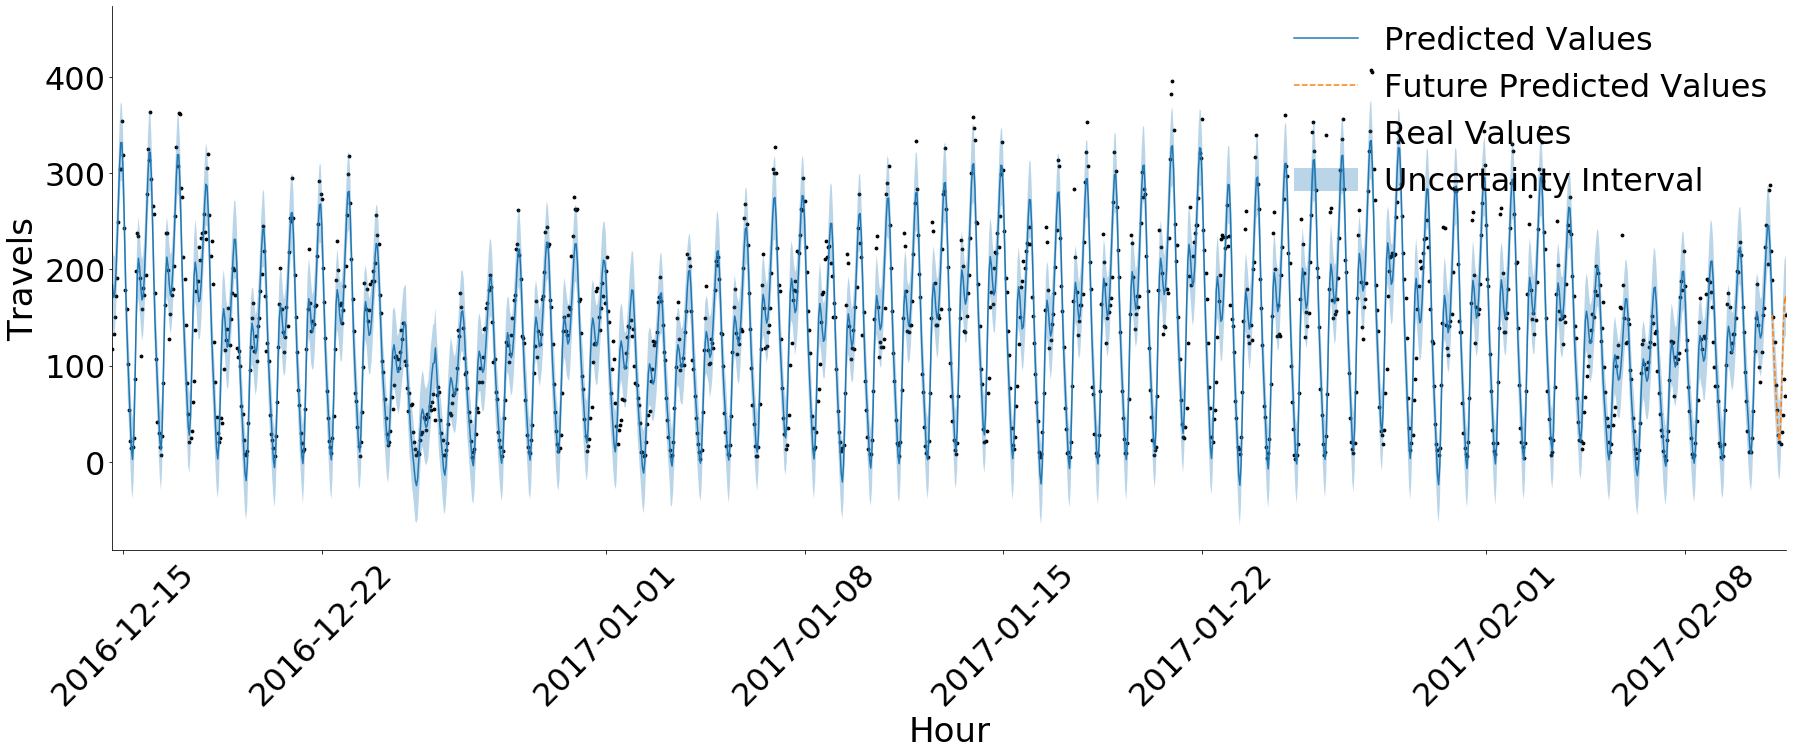

In [20]:
plot_forecast(c2g_prophet, c2g_forecast,PREDICT_PERIOD, **plot_styling)

In [22]:
prediction = c2g_model.predict(c2g_test[['ds']])
print(eval_model(c2g_test.y, prediction.yhat))

{'rmse': 38.625197417341724, 'mse': 1491.905875528622, 'mae': 29.352289449091916, 'r2': 0.8565089797548335}


In [ ]:
c2g_auto_feed = test_auto_feed(c2g_params, c2g_train, c2g_test, path='JISA/prophet/')

In [ ]:
c2g_future = test_future_period(c2g_params, c2g_train, c2g_test, path='JISA/prophet/')